# Two sources and control data pre-processing and analysis

This notebook documents analysis of the initial "two source" study in the crazy beliefs project. This was among the earliest studies run so the data is in a different format than that employed in more recent studies. This workbook reads in the logistic classification parameters from grid 1 and grid 2 for each subject in both experimental (sources at 135/250 and 165/50) and control conditions (no source labels), as well as explicit boundary labels and source rating data. 

## Functions

Define or read functions here

In [1]:
zscore <- function(v){
    #Z-scores values in a numeric vector v, ignoring NA entries
    (v-mean(v, na.rm=T))/sqrt(var(v, na.rm=T))
}

In [37]:
get.pars <- dget("get_pars.r")
plot.bars <- dget("plot_bars.r")
plot.cis <- dget("plot_cis.r")
get.mv.bnd <- dget("get_mvbound.r")

## Read data

In [3]:
#Read in the grid data:
d <- read.csv("two15_and_allcont_grid_pars.csv", header = T)
head(d)

PID,cond,axlab,closebound,cbside,sno,FaceLeft,t1int,t1slope,t1bound,t2int,t2slope,t2bound,bshift,AlShift,ZAlShift,t1dist
none_C_pass_11,none,C,NA,control,11,1,11.370928,-0.06685196,170.0912,17.552066,-0.08995508,195.12035,25.02918,25.02918,-0.1251598,NA
none_C_pass_110,none,C,NA,control,110,2,643.490304,-4.15156952,154.9993,351.382156,-2.06695386,170.00000,15.00072,15.00072,-0.1768209,NA
none_C_pass_12,none,C,NA,control,12,2,6.945626,-0.04476881,155.1443,3.603997,-0.03798525,94.87886,-60.26547,-60.26547,-0.5645507,NA
none_C_pass_13,none,C,NA,control,13,1,26.870491,-0.16794057,160.0000,7.166546,-0.05523562,129.74500,-30.25500,-30.25500,-0.4099533,NA
none_C_pass_14,none,C,NA,control,14,2,23.511679,-0.16794057,140.0000,441.814737,-2.00824880,220.00000,80.00000,80.00000,0.1580195,NA
none_C_pass_15,none,C,NA,control,15,1,26.870491,-0.16794057,160.0000,7.571491,-0.04045877,187.14092,27.14092,27.14092,-0.1142813,NA


How many subjects in each condition?

In [4]:
aggregate(t1bound~cbside, data = d, FUN="length")

cbside,t1bound
control,39
left,20
right,20


## Outlier removal

The grid analyses involve using logistic regression to predict binary category decisions from the continuous 1D variable that indicates the object shape, for the initial and the final boundary. This measure can be strongly influenced by a few errors or patches of random responding. We therefore remove subjects with extreme boundary or boundary-shift estimates as follows.

First we remove subjects with estimated boundaries outside the stimulus range (less than 0, more than 300) in either test 1 or test 2. Next, since all subjects have the same experience through to test 1, we use all subjects to estimate the mean and standard error of the test 1 boundary estimate, and remove subjects with an extreme estimate (more than 2.5 SD from mean). Finally we compute means and standard deviations for the aligned boundary shift estimate, separately for control and experimental conditions (since these have different expected shifts), and remove subjects more than 2.5 SDs from the respective mean.

In [5]:
zthresh <- 2.0

Check for impossible values in t1bound and t2bound

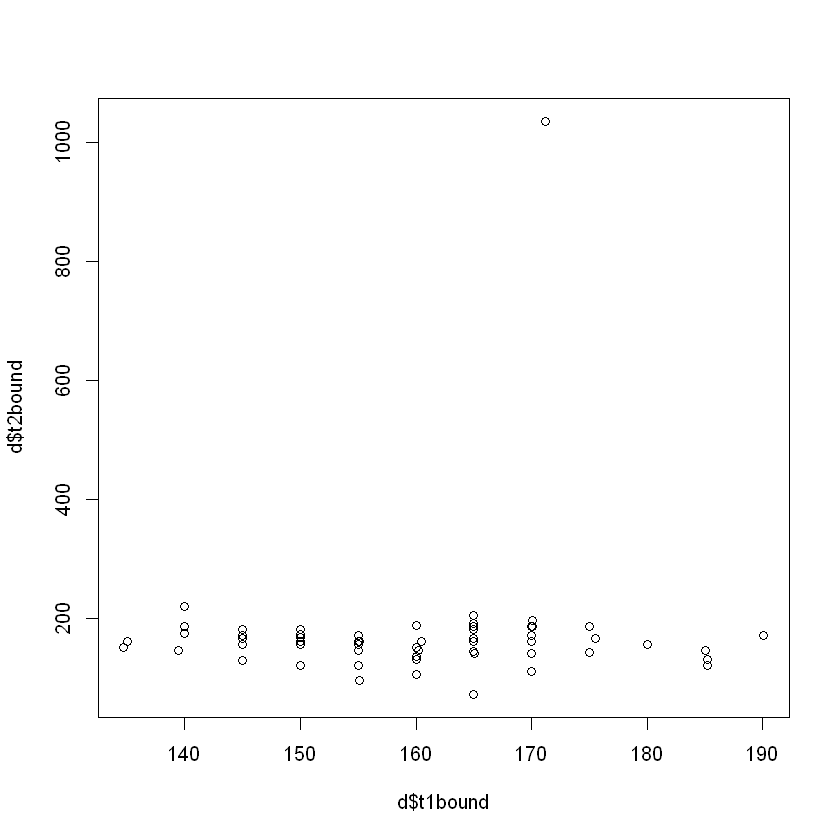

In [6]:
plot(d$t1bound, d$t2bound)

There is one impossible value for t2bound so add this subject to the exclusion list and remove from the data

In [7]:
dim(d)
sjex <- as.character(d$PID[d$t2bound > 300]) #Add subject number to exclude list for sj with a boundary outside the allowable range
noo <- d[is.na(match(d$PID, sjex)),]  #Remove all subjects on exclude list from no-outlier object
dim(noo)   #Look how many left to make sure only one was removed

[1] 79 17

[1] 78 17

Write "no impossible" (nimp) file for later agglomeration in mega data

In [8]:
write.csv(noo, "summary/two15_allcont_grid_nimp.csv", row.names=F, quote=F)

Look for outliers in t1bound

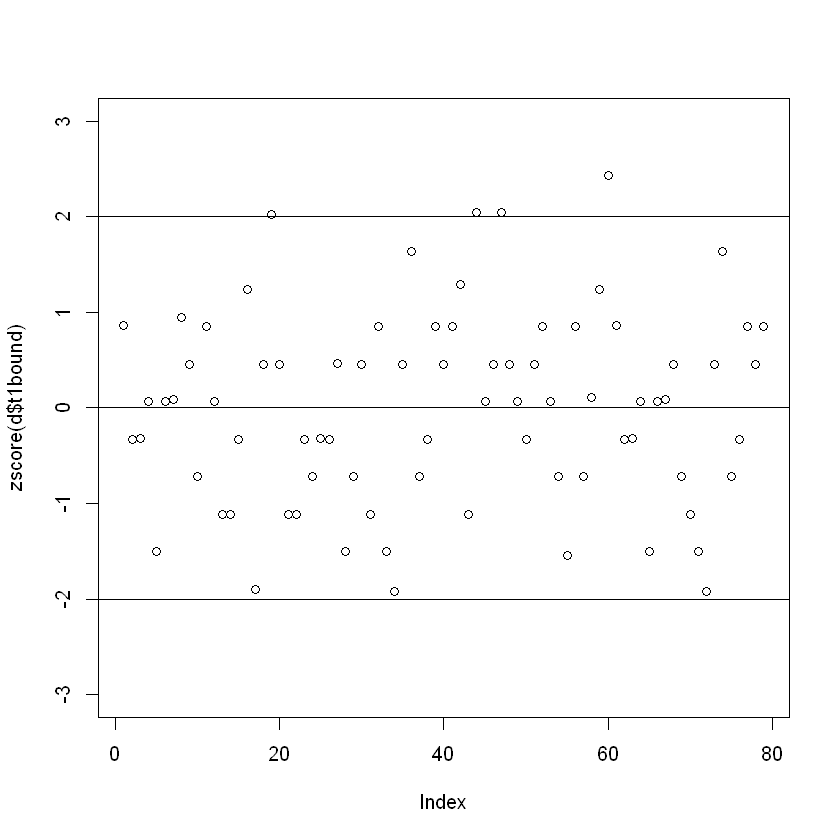

In [9]:
plot(zscore(d$t1bound), ylim = c(-3,3))
abline(h=c(-zthresh,0,zthresh))

Add any outliers to exclude list and remove from noo object

In [10]:
sjex <- c(sjex, as.character(noo$PID[abs(zscore(noo$t1bound)) > zthresh])) #add outliers to exclude list
noo <- unique(noo) #remove any accidental outliers
noo <- noo[is.na(match(noo$PID, sjex)),] #remove from noo object
dim(noo)

[1] 74 17

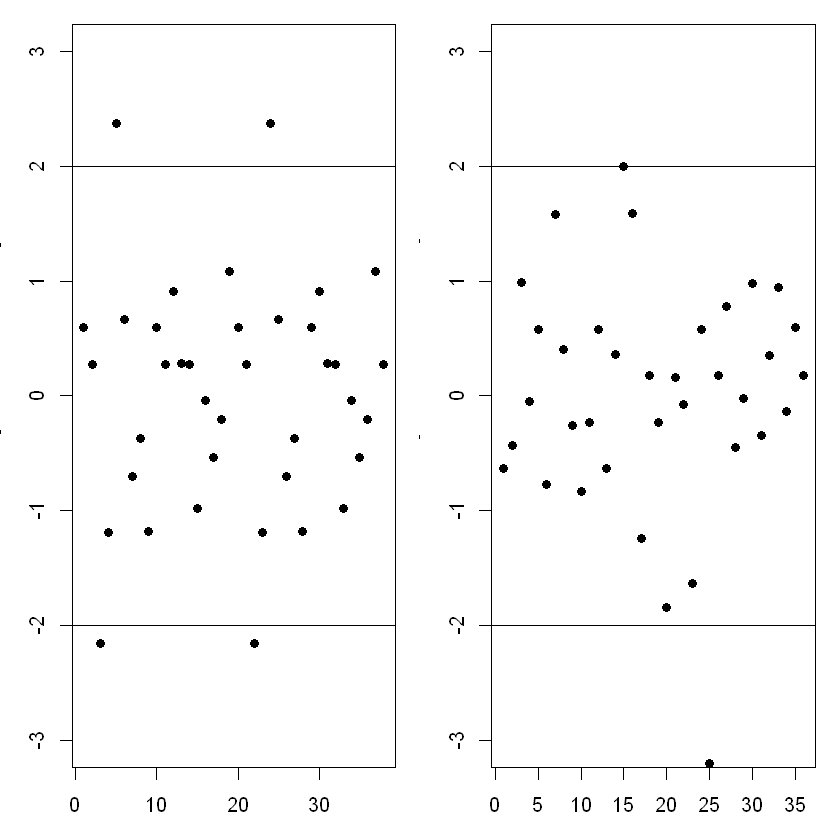

In [11]:
par(mfrow = c(1,2), mar = c(3,3,1,1)) #Prepare 2=panel plot
noo$ZAlShift[noo$cond=="none"] <- zscore(noo$AlShift[noo$cond=="none"]) #compute zscores for control condition
noo$ZAlShift[noo$cond=="two15"] <- zscore(noo$AlShift[noo$cond=="two15"]) #compute zscores for experimental condition
plot(noo$ZAlShift[noo$cond=="none"], pch=16, ylim = c(-3,3)) #For control condition
abline(h=c(zthresh,-zthresh))
plot(noo$ZAlShift[noo$cond=="two15"], pch=16, ylim = c(-3,3)) #For control condition
abline(h=c(zthresh,-zthresh))

Add any outliers to exclude list and remove from data

In [12]:
sjex <- c(sjex, as.character(noo$PID[abs(noo$ZAlShift)>zthresh]))  #Remove subjects with boundary shift > 2 SD from mean
sjex <- unique(sjex)   # Remove any duplicates in exclusion list
noo <- d[is.na(match(d$PID, sjex)),]  #Remove all subjects on exclude list from data and assign to no-outlier object
dim(noo)  #CHeck number left to make sure two were removed

[1] 68 17

## Data analysis

Compute confidence interval for aligned boundary shift and ttest against zero for control condition

In [13]:
t.test(noo$AlShift[noo$cond=="none"])


	One Sample t-test

data:  noo$AlShift[noo$cond == "none"]
t = 1.6204, df = 33, p-value = 0.1147
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -1.548003 13.663209
sample estimates:
mean of x 
 6.057603 


Mean shift does not differ from zero for control condition. Now compute CI and ttest for experimental condition:

In [14]:
t.test(noo$AlShift[noo$cond=="two15"])


	One Sample t-test

data:  noo$AlShift[noo$cond == "two15"]
t = -3.9949, df = 33, p-value = 0.0003414
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -20.353764  -6.617731
sample estimates:
mean of x 
-13.48575 


Shift in experimental condition is reliably negative (toward far source), p < 0.001

Now we should check whether experimental and control conditions differ.

In [15]:
#T test to see if control and experimental conditions have different mean shifts
t.test(AlShift ~ cond, data=noo)



	Welch Two Sample t-test

data:  AlShift by cond
t = 3.88, df = 65.325, p-value = 0.0002455
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  9.484889 29.601813
sample estimates:
 mean in group none mean in group two15 
           6.057603          -13.485747 


Experimental and control conditions differ reliably.

Now let's see if the initial boundaries differ by group:

In [16]:
summary(lm(t1bound ~ cbside, data = noo))


Call:
lm(formula = t1bound ~ cbside, data = noo)

Residuals:
    Min      1Q  Median      3Q     Max 
-24.097  -8.533   1.467   8.883  21.467 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  158.533      1.966  80.649   <2e-16 ***
cbsideleft    -2.415      3.341  -0.723    0.472    
cbsideright    0.566      3.475   0.163    0.871    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 11.46 on 65 degrees of freedom
Multiple R-squared:  0.01074,	Adjusted R-squared:  -0.0197 
F-statistic: 0.3529 on 2 and 65 DF,  p-value: 0.704


Neither experimental group differs from the control condition. Do they differ from one another?

In [17]:
t.test(t1bound~closebound, data = noo) #Controls are excluded here b/c closeboudn is NA for these


	Welch Two Sample t-test

data:  t1bound by closebound
t = -0.76871, df = 30.589, p-value = 0.448
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -10.895984   4.933095
sample estimates:
mean in group 135 mean in group 165 
         156.1180          159.0994 


No they don't. For the record, let's compute the confidence intervals for the initial boundary across all subjects.

In [18]:
t.test(noo$t1bound)


	One Sample t-test

data:  noo$t1bound
t = 114.81, df = 67, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 155.2797 160.7746
sample estimates:
mean of x 
 158.0272 


The initial boundary is a bit shifted compared to the midpoint between labeled examples at 150.  

What about at test 2?

In [19]:
t.test(t2bound~closebound, data = noo)


	Welch Two Sample t-test

data:  t2bound by closebound
t = 4.096, df = 29.259, p-value = 0.0003041
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 12.10261 36.22402
sample estimates:
mean in group 135 mean in group 165 
         168.2176          144.0543 


At test 2 the boundary estimates for the two experimental groups differ with p < 0.001. In other words, the two groups start off in agreement about the location of the category boundary, but end up disagreeing. What are the confidence intervals for the group means?

In [20]:
t.test(noo$t2bound[noo$closebound==165]) #Mean and intervals for sources at 165, 50


	One Sample t-test

data:  noo$t2bound[noo$closebound == 165]
t = 30.975, df = 15, p-value = 5.183e-15
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 134.1417 153.9669
sample estimates:
mean of x 
 144.0543 


In [21]:
t.test(noo$t2bound[noo$closebound==135]) #Mean and intervals for sources at 135, 250


	One Sample t-test

data:  noo$t2bound[noo$closebound == 135]
t = 46.348, df = 17, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 160.5601 175.8751
sample estimates:
mean of x 
 168.2176 


In both cases the confidence limits for the t2bound exclude the location of the close source (165 for L and 135 for R) and the midpoint between the initial boundary and the far source (at ~106 for L and ~203 for R). So the boundary appears to move away from the close source, toward the far source, but not to the midpoint between these.

### Summary

The three groups form boundaries in the same zone. When no additional labels are provided by the sources, the boundary does not shift. When learners receive labels from two sources, one using a boundary close to the learner's initial belief and one quite far, the learner's boundary shifts reliably away from the closer source and toward the further source, but not all the way to the midpoint between these as might be expected if both sources were given equal weighting.

### Write csv files

In [22]:
write.csv(noo, paste("two15_allcont_noo_z", zthresh*10,".csv",sep=""), row.names=F, quote=F)

## Analysis of explicit source ratings

Next we want to see whether participants explicitly rate the two sources differently in their overall knowledge, accuracy, trustworthiness, and as a control, attractiveness. Subjects rated each face on a 100-point Likert scale for each question. The central question is whether ratings differ for the face paired with the closer category boundary versus the face paired with the farther boundary. Exactly which face image was paired with "close" vs "far" was counterbalanced across participants.

Face ratings were also collected for the control (no source) condition. Control participants viewed the two face images on every trial, but without any associated category label. At the end they completed the same ratings questions. This allowed us to assess, in the experimental group, whether ratings of a given face image ("Mark" or "John") were generally higher, lower, or the same relative to control, depending on whether the face was paired with the close or far category boundary. To do this, ratings for participants in the experimental condition were Z-scored based on the scores provided for a given face and question in the control condition. For each question we computed the mean and standard deviation of the ratings for each image from the control data. For each participant in the experimental condition, we computed the Z-score of the participant's rating for a given image relative to the control distribution for the same image and question. We then looked to see whether these Z-scored ratings differed reliably depending on whether the face was paired with the "close" or the "far" boundary.

In [23]:
d <- read.csv("allpars.csv", header = T) #Read all data from orig experiment
noo <- d[is.na(match(d$PID, sjex)),]   #Remove any outlying subject from prior analysis
e <- noo[noo$cbside!="control",] #Take just subjects in the experimental condition
dim(e)

[1] 34 40

In [24]:
t.test(e$ZKnowClose, e$ZKnowFar, paired=T) #Ttest for knowledge


	Paired t-test

data:  e$ZKnowClose and e$ZKnowFar
t = 3.2772, df = 28, p-value = 0.002798
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.4031262 1.7471025
sample estimates:
mean of the differences 
               1.075114 


In [25]:
t.test(e$ZAccClose, e$ZAccFar, paired=T) #Ttest for accuracy


	Paired t-test

data:  e$ZAccClose and e$ZAccFar
t = 3.3313, df = 28, p-value = 0.002437
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.4133866 1.7334985
sample estimates:
mean of the differences 
               1.073443 


In [26]:
t.test(e$ZTrustClose, e$ZTrustFar, paired=T) #Ttest for trust


	Paired t-test

data:  e$ZTrustClose and e$ZTrustFar
t = 3.5995, df = 28, p-value = 0.001216
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.4428714 1.6126174
sample estimates:
mean of the differences 
               1.027744 


In [27]:
t.test(e$ZAttClose, e$ZAttFar, paired=T) #Ttest for attractiveness


	Paired t-test

data:  e$ZAttClose and e$ZAttFar
t = -0.67507, df = 28, p-value = 0.5052
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.6529631  0.3292635
sample estimates:
mean of the differences 
             -0.1618498 


Ratings for close source are reliably higher than far source for knowledge, trust, and accuracy, but not attractiveness.

Now pull out mean Z scores for ratings in experimental condition

In [28]:
#Pull out means, stopre in tmp object
tmp <- aggregate(ZKnowClose ~ cbside, data=e, FUN="mean")
tmp <- cbind(tmp, aggregate(ZKnowFar ~ cbside, data=e, FUN="mean")[,2])
tmp <- cbind(tmp, aggregate(ZTrustClose ~ cbside, data=e, FUN="mean")[,2])
tmp <- cbind(tmp, aggregate(ZTrustFar ~ cbside, data=e, FUN="mean")[,2])
tmp <- cbind(tmp, aggregate(ZAccClose ~ cbside, data=e, FUN="mean")[,2])
tmp <- cbind(tmp, aggregate(ZAccFar ~ cbside, data=e, FUN="mean")[,2])
tmp <- cbind(tmp, aggregate(ZAttClose ~ cbside, data=e, FUN="mean")[,2])
tmp <- cbind(tmp, aggregate(ZAttFar ~ cbside, data=e, FUN="mean")[,2])
row.names(tmp)<-c("Cont","Exp")
tmp <- tmp[,2:9]
facezmn <- as.data.frame(matrix(tmp[2,], 4, 2, byrow=T))
names(facezmn)<-c("Close","Far")
row.names(facezmn)<-c("Know","Trust","Acc","Attr")
facezmn

,Close,Far
Know,1.052073,-0.3638304
Trust,0.790683,-0.6207192
Acc,1.095651,-0.6153223
Attr,-0.06120225,0.2826366


Plot ratings for close and far sources in experimental condition, with standard error bars

In [29]:
head(e[,20:27])

,ExpShift,AlExShift,ZAlExShift,sjnum,KnowClose,KnowFar,TrustClose,TrustFar
11,NA,NA,NA,11,NA,NA,NA,NA
12,13,13,0.3658374,110,98,21,95,28
13,-134,-134,-1.4898104,12,74,35,72,38
14,40,40,0.7066707,13,64,70,66,36
15,-27,-27,-0.1391008,14,61,38,96,32
16,NA,NA,NA,15,NA,NA,NA,NA


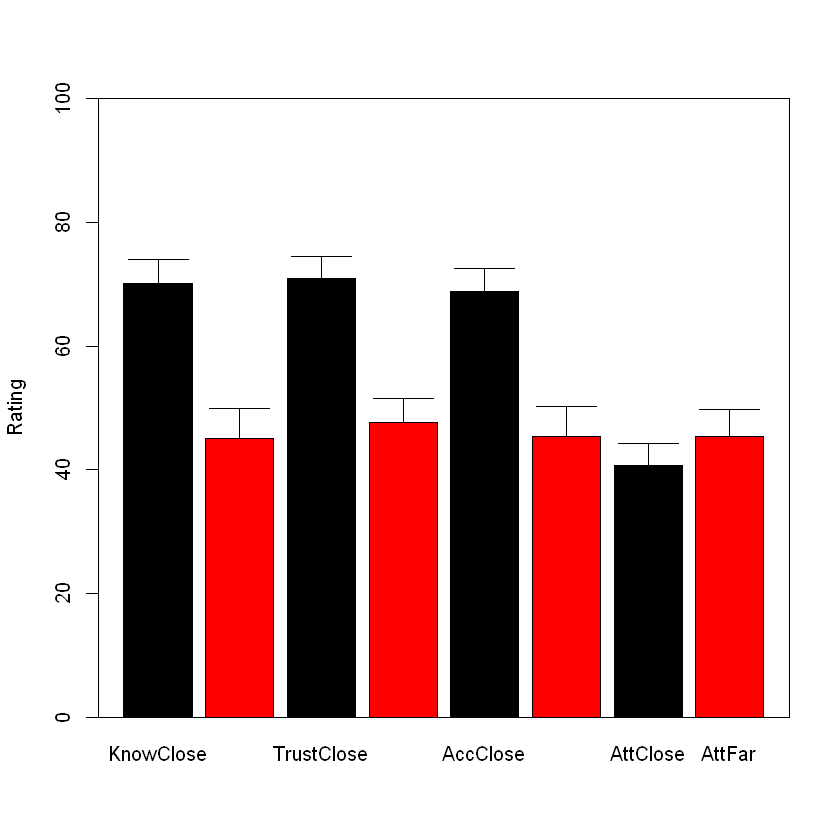

In [30]:
rface <- as.matrix(e[,24:31])  #Un-normalized face ratings
plot.bars(rface, c(1,2), y.lim = c(0,100), y.lab="Rating")

Plot confidence intervals for z-scored ratings in experimental condition

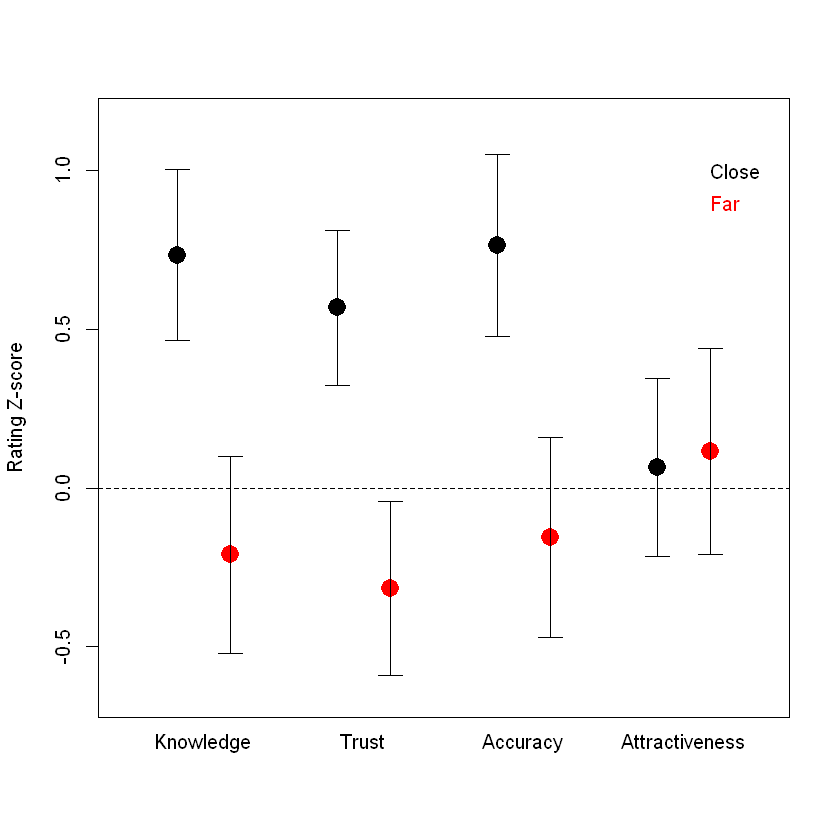

In [31]:
zface <- as.matrix(noo[,32:39])
plot.cis(zface, pcol=c(1,2), x=c(1,2,4,5,7,8,10,11), y.lab="Rating Z-score")
mtext(side = 1, line=.5, at = c(1.5, 4.5, 7.5,10.5), text=c("Knowledge","Trust","Accuracy","Attractiveness"))
abline(h=0, lty=2)
text(c(11,11), c(1,.9), labels=c("Close","Far"), col=c(1,2), adj=0)

So close sources receive higher ratings of knowledge, accuracy, and trust but not attractiveness relative to controls, but far sources don't receive lower ratings, except possibly for trust. 

## Scratch

In [32]:
cf <- read.csv("control_face_ratings.csv", header = T)
head(cf)

Spiky,Pno,PID,KnowAdam,KnowMark,TrustAdam,TrustMark,AccAdam,AccMark,AttAdam,AttMark
C,1,C1,50,54,27,27,55,52,38,65
C,2,C2,11,20,39,45,65,56,35,67
C,3,C3,81,43,50,50,35,65,50,44
C,4,C4,38,65,17,13,59,59,59,38
C,5,C5,36,81,76,14,26,28,19,35
C,6,C6,19,76,46,80,19,10,42,53


In [33]:
t.test(cf$KnowMark, cf$KnowAdam, paired=T)



	Paired t-test

data:  cf$KnowMark and cf$KnowAdam
t = 0.067256, df = 18, p-value = 0.9471
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -14.32321  15.27057
sample estimates:
mean of the differences 
              0.4736842 


In [34]:
t.test(cf$TrustMark, cf$TrustAdam, paired=T)


	Paired t-test

data:  cf$TrustMark and cf$TrustAdam
t = 0.10905, df = 18, p-value = 0.9144
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -13.45953  14.93321
sample estimates:
mean of the differences 
              0.7368421 


In [35]:
t.test(cf$AccMark, cf$AccAdam, paired=T)


	Paired t-test

data:  cf$AccMark and cf$AccAdam
t = -0.97679, df = 18, p-value = 0.3416
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -22.221729   8.116466
sample estimates:
mean of the differences 
              -7.052632 


In [36]:
t.test(cf$AttMark, cf$AttAdam, paired=T)


	Paired t-test

data:  cf$AttMark and cf$AttAdam
t = -0.39394, df = 18, p-value = 0.6983
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -16.99937  11.63095
sample estimates:
mean of the differences 
              -2.684211 


## Further analyses

In [38]:
nsj <- length(alldat)    #Number of subjects is length of alldat object
mvbnd <- matrix(0, nsj, 301)  #Initialize matrix of 0s to hold boundary-movement data, with 301 windows
for(i1 in c(1:nsj)) mvbnd[i1,] <- get.mv.bound(alldat, sj=i1) #Compute move data for each sj and store in matrix rows


ERROR: Error in eval(expr, envir, enclos): object 'alldat' not found
